## IMPORTS


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import seaborn as sns
import os
import glob 
import json 
import datetime


## Presentation 1 - Number of Tweets by Reply Count Range


### DATA LOAD 


#### Data DF1


In [5]:

DATA_DIR_PATH = r"C:\Users\20243898\Downloads\cleaned_data_2\cleaned_final\cleaned"
PLOTS_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), 'Downloads', 'airline_reply_count_plots_standalone')
os.makedirs(PLOTS_OUTPUT_DIR, exist_ok=True)
print(f"Input JSONs from: {DATA_DIR_PATH}")
print(f"Plots will be saved to: {PLOTS_OUTPUT_DIR}")

sns.set(style="whitegrid") 
pd.options.display.float_format = '{:.1f}'.format 

# 1. Data Loading & Preparation 
all_files = glob.glob(os.path.join(DATA_DIR_PATH, '*_cleaned.json')) 

if not all_files:
    print(f"ERROR: No JSON files matching '*_cleaned.json' found in {DATA_DIR_PATH}.")
    df = pd.DataFrame() 
else:
    print(f"Found {len(all_files)} JSON files. Loading...")
    li = []
    for filename in all_files:
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                file_data = [json.loads(line) for line in f if line.strip()]
            if file_data:

                df_temp = pd.DataFrame.from_records(file_data)

                if 'reply_count' in df_temp.columns:
                    li.append(df_temp[['reply_count']])

        except Exception as e:
            print(f"Error loading or parsing {os.path.basename(filename)}: {e}.")

    if li:
        df = pd.concat(li, axis=0, ignore_index=True)
        print(f"Successfully loaded 'reply_count' from {len(df):,} tweets (from {len(li)} files).")

        if 'reply_count' in df.columns:
            df['reply_count'] = pd.to_numeric(df['reply_count'], errors='coerce')
            print(f"  'reply_count' NaNs after coercion: {df['reply_count'].isnull().sum()}")
        else:
            print("WARNING: 'reply_count' column was not found in any loaded file.")
            df['reply_count'] = pd.Series(dtype='float') 

    else:
        print("No data loaded, or 'reply_count' missing in all files.")
        df = pd.DataFrame()


Input JSONs from: C:\Users\20243898\Downloads\cleaned_data_2\cleaned_final\cleaned
Plots will be saved to: C:\Users\20243898\Downloads\airline_reply_count_plots_standalone
Found 567 JSON files. Loading...
Successfully loaded 'reply_count' from 6,185,961 tweets (from 567 files).
  'reply_count' NaNs after coercion: 0


## Visualization Code

### Visualization 1


--- Analyzing Reply Count Ranges ---


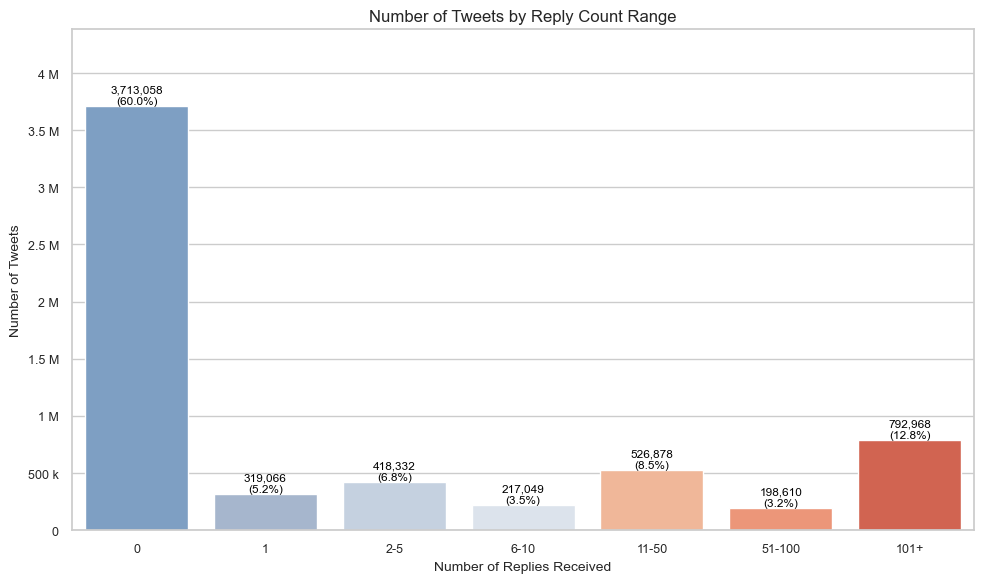


--- Reply Count Range Analysis Complete ---


In [6]:
# 2. Plotting Distribution of Replies Received per Tweet
if not df.empty and 'reply_count' in df.columns and df['reply_count'].notna().any():
    print("\n--- Analyzing Reply Count Ranges ---")

    
    df['reply_count_for_binning'] = df['reply_count'].fillna(-1)
    max_replies = df['reply_count_for_binning'].max()

   
    if pd.notna(max_replies):
      
        bins = [-1, 0, 1, 5, 10, 50, 100, max_replies + 1 if max_replies >=100 else 101]
        labels = ['0', '1', '2-5', '6-10', '11-50', '51-100', '101+']

 
        if max_replies < 100:
            
            original_bins_len = len(bins)
            for i in range(len(bins) - 2, -1, -1): 
                if max_replies >= bins[i]: 
                    bins = bins[:i+2] 
                    labels = labels[:i+1] 
                    
                    if max_replies >= bins[-1] : 
                         bins.append(max_replies + 1)
                         labels.append(f'{bins[-2]+1 if bins[-2] != -1 else 1}-{int(max_replies)}' if bins[-2]+1 <= max_replies else str(int(max_replies)))
                         if labels[-1] == '0-0': labels[-1] = '0' 
                    break
         
            if len(bins) == 1 and bins[0] == -1 :
                 bins = [-1, 0, 1]
                 labels = ['0', '1']

     
        try:
            df['reply_bin'] = pd.cut(df['reply_count_for_binning'], bins=bins, labels=labels, right=True, include_lowest=True)
        except ValueError as e:
            print(f"Error during pd.cut for reply_bin: {e}")
            print(f"Bins: {bins}, Labels: {labels}, Max Replies: {max_replies}")
            df['reply_bin'] = pd.Series(dtype='category') 

        if 'reply_bin' in df.columns and df['reply_bin'].notna().any():
            plt.figure(figsize=(10, 6))

            reply_bin_counts = df['reply_bin'].value_counts().reindex(labels).fillna(0)

            palette_map = {'0': '#729ECE','1': '#A0B5D3','2-5': '#C0D0E5','6-10': '#D9E2EF','11-50': '#FFB38A','51-100':'#FF8C66','101+':  '#E6553C'}
    
            current_palette = [palette_map.get(str(label), sns.color_palette("coolwarm", n_colors=len(reply_bin_counts))[i % len(sns.color_palette("coolwarm", n_colors=len(reply_bin_counts)))]) for i, label in enumerate(reply_bin_counts.index)]


            ax_bin = sns.barplot(x=reply_bin_counts.index, y=reply_bin_counts.values, palette=current_palette) 
            plt.title('Number of Tweets by Reply Count Range', fontsize=12)
            plt.xlabel('Number of Replies Received', fontsize=10)
            plt.ylabel('Number of Tweets', fontsize=10)
            plt.xticks(fontsize=9); plt.yticks(fontsize=9)
            ax_bin.yaxis.set_major_formatter(mticker.EngFormatter()) 

            total_tweets_with_reply_info = df['reply_count_for_binning'].notna().sum()
            if total_tweets_with_reply_info > 0:
                for bar in ax_bin.patches:
                    height = bar.get_height()
                    if height > 0:
                        percentage = (height / total_tweets_with_reply_info) * 100
                        ax_bin.text(bar.get_x() + bar.get_width() / 2., height,
                                    f'{int(height):,}\n({percentage:.1f}%)',
                                    ha='center', va='bottom', fontsize=8.5, color='black')

            ax_bin.set_ylim(0, reply_bin_counts.max() * 1.18 if reply_bin_counts.max() > 0 else 10)
            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_OUTPUT_DIR, 'overall_reply_distribution_bins_styled.png'))
            plt.show()
        else:
            print("No valid 'reply_bin' data to plot.")
    else:
        print("Could not determine valid maximum reply count for binning, or 'reply_count' has all NaNs.")
else:
    print("DataFrame 'df' is empty or 'reply_count' column not found. Cannot plot reply distribution.")

print("\n--- Reply Count Range Analysis Complete ---")


## Presentation 2 - Overall Sentiment Label Distribution


### DATA LOAD

### Data DF2


In [7]:
DATA_DIR_PATH = r"C:\Users\20243898\Downloads\sent_analysis_data\cleaned_sent_2\cleaned_sent_2" 
PLOTS_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), 'Downloads', 'overall_sentiment_plot_only_v4') # v4
os.makedirs(PLOTS_OUTPUT_DIR, exist_ok=True)
print(f"Input JSONs from: {DATA_DIR_PATH}")
print(f"Plots will be saved to: {PLOTS_OUTPUT_DIR}")

sns.set_style("whitegrid")
pd.options.display.float_format = '{:.1f}'.format

# 1 Data Loading & Minimal Preparation 
all_files = glob.glob(os.path.join(DATA_DIR_PATH, '*_cleaned.json'))

if not all_files:
    print(f"ERROR: No JSON files matching '*_cleaned.json' found in {DATA_DIR_PATH}.")
    df2 = pd.DataFrame()
else:
    print(f"Found {len(all_files)} JSON files. Loading 'sentiment_max' or 'sentiment_label'...")
    li = []
    for filename in all_files:
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                file_data = [json.loads(line) for line in f if line.strip()]
            if file_data:
                df2_temp = pd.DataFrame.from_records(file_data)
                cols_to_keep = []
                if 'sentiment_max' in df2_temp.columns:
                    cols_to_keep.append('sentiment_max')
                elif 'sentiment_label' in df2_temp.columns:
                    df2_temp.rename(columns={'sentiment_label':'sentiment_max'}, inplace=True)
                    cols_to_keep.append('sentiment_max')
                if cols_to_keep: li.append(df2_temp[cols_to_keep])
        except Exception as e: print(f"Error loading {os.path.basename(filename)}: {e}.")

    if li:
        df2 = pd.concat(li, axis=0, ignore_index=True)
        print(f"Successfully loaded sentiment column from {len(df2):,} tweets.")
        if 'sentiment_max' in df2.columns:
            label_map = {'neg':'negative', 'neu':'neutral', 'pos':'positive'}
            df2['sentiment_label'] = df2['sentiment_max'].replace(label_map).astype('category')
        elif 'sentiment_label' not in df2.columns: 
             print("ERROR: 'sentiment_label' could not be created."); df2 = pd.DataFrame()
    else:
        print("No data loaded or required sentiment column missing."); df2 = pd.DataFrame()

    

Input JSONs from: C:\Users\20243898\Downloads\sent_analysis_data\cleaned_sent_2\cleaned_sent_2
Plots will be saved to: C:\Users\20243898\Downloads\overall_sentiment_plot_only_v4
Found 567 JSON files. Loading 'sentiment_max' or 'sentiment_label'...
Successfully loaded sentiment column from 6,094,135 tweets.


## Visualization Code

### Visualization 2


--- Plotting Overall Sentiment Label Distribution ---


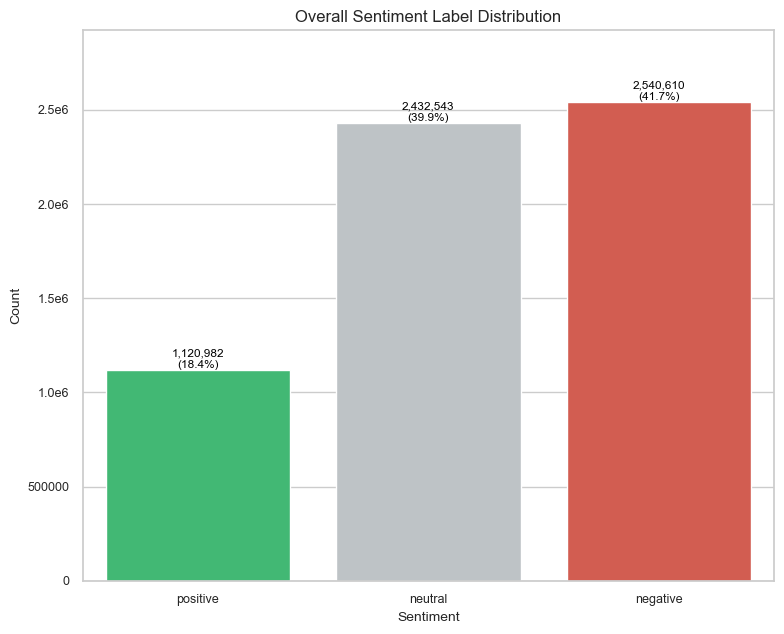


Counts:
 sentiment_label
positive    1120982
neutral     2432543
negative    2540610
Name: count, dtype: int64

--- Overall Sentiment Label Plotting Complete ---


In [8]:
# 2 Code to Generate "Overall Sentiment Label Distribution" Graph 
if 'df2' in locals() and not df2.empty and 'sentiment_label' in df2.columns and df2['sentiment_label'].notna().any():
    print("\n--- Plotting Overall Sentiment Label Distribution ---")
    plt.figure(figsize=(8, 6.5)) 
    sentiment_order = ['positive', 'neutral', 'negative']
    plot_df_counts = df2['sentiment_label'].value_counts().reindex(sentiment_order, fill_value=0)

    palette_colors_exact = {'positive': '#2ECC71', 'neutral': '#BDC3C7', 'negative': '#E74C3C'} 
    current_palette = [palette_colors_exact.get(label, "#CCCCCC") for label in plot_df_counts.index]

    ax = sns.barplot(x=plot_df_counts.index, y=plot_df_counts.values, palette=current_palette) 

    plt.title('Overall Sentiment Label Distribution', fontsize=12)
    plt.xlabel('Sentiment', fontsize=10); plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=9); plt.yticks(fontsize=9)

    def y_axis_formatter(x, pos):
        if x >= 1e6: return f'{x/1e6:.1f}e6'
        return f'{int(x)}'
    ax.yaxis.set_major_formatter(plt.FuncFormatter(y_axis_formatter))

    total_tweets_with_label = plot_df_counts.sum()
    if total_tweets_with_label > 0:
        for bar in ax.patches:
            height = bar.get_height()
            if height >= 0:
                percentage = (height / total_tweets_with_label) * 100
                ax.text(bar.get_x()+bar.get_width()/2., height, f'{int(height):,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8.5, color='black')

    ax.set_ylim(0, plot_df_counts.max() * 1.15 if plot_df_counts.max() > 0 else 10)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_OUTPUT_DIR, 'overall_sentiment_label_distribution_target.png'))
    plt.show()
    print("\nCounts:\n", plot_df_counts)
else:
    if 'df' not in locals() or df2.empty: print("DataFrame 'df' is not loaded or is empty.")
    elif 'sentiment_label' not in df2.columns: print("Column 'sentiment_label' not found.")
    else: print("Column 'sentiment_label' has no valid data to plot.")
print("\n--- Overall Sentiment Label Plotting Complete ---")


## Presentation 2 - Sentiment of Tweets for Lufthansa

### DATA LOAD

#### Data DF3

In [9]:
DATA_DIR_PATH = r"C:\Users\20243898\Downloads\sent_analysis_data\cleaned_sent_2\cleaned_sent_2" 
PLOTS_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), 'Downloads', 'lufthansa_sentiment_plot_standalone')
os.makedirs(PLOTS_OUTPUT_DIR, exist_ok=True)
print(f"Input JSONs from: {DATA_DIR_PATH}")
print(f"Plots will be saved to: {PLOTS_OUTPUT_DIR}")

# Define Lufthansa's user ID string

AIRLINE_HANDLES = {'Lufthansa': 124476322} 
AIRLINE_IDS_STR = {str(v): k for k, v in AIRLINE_HANDLES.items()}
LUFTHANSA_USER_ID = str(AIRLINE_HANDLES['Lufthansa'])

sns.set_style("whitegrid") 
pd.options.display.float_format = '{:.1f}'.format

# 1 Data Loading & Minimal Preparation
all_files = glob.glob(os.path.join(DATA_DIR_PATH, '*_cleaned.json')) 

if not all_files:
    print(f"ERROR: No JSON files matching '*_cleaned.json' found in {DATA_DIR_PATH}.")
    df3 = pd.DataFrame()
else:
    print(f"Found {len(all_files)} JSON files. Loading...")
    li = []
    for filename in all_files:
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                file_data = [json.loads(line) for line in f if line.strip()]
            if file_data:
                df3_temp = pd.DataFrame.from_records(file_data)
             
                cols_to_keep_for_plot = []
                if 'user' in df3_temp.columns: cols_to_keep_for_plot.append('user')
                if 'sentiment_max' in df3_temp.columns: cols_to_keep_for_plot.append('sentiment_max')
                elif 'sentiment_label' in df3_temp.columns: 
                    df3_temp.rename(columns={'sentiment_label':'sentiment_max'}, inplace=True)
                    cols_to_keep_for_plot.append('sentiment_max')

                if cols_to_keep_for_plot: 
                    li.append(df3_temp[cols_to_keep_for_plot])
        except Exception as e:
            print(f"Error loading or parsing {os.path.basename(filename)}: {e}.")

    if li:
        df3 = pd.concat(li, axis=0, ignore_index=True)
        print(f"Successfully loaded relevant columns from {len(df3):,} tweets (from {len(li)} files).")

        
        if 'user' in df3.columns: 
            df3['user_id_str'] = df3['user'].apply(lambda x: x.get('id_str') if isinstance(x, dict) else None).astype('string')
            df3.drop('user', axis=1, inplace=True, errors='ignore')
            df3['airline_name'] = df3['user_id_str'].map(AIRLINE_IDS_STR).astype('category')
        elif 'user_id_str' in df3.columns: 
            df3['user_id_str'] = df3['user_id_str'].astype('string')
            df3['airline_name'] = df3['user_id_str'].map(AIRLINE_IDS_STR).astype('category')
        else:
            print("WARNING: 'user' or 'user_id_str' column not found. Cannot identify Lufthansa tweets.")
            df3['airline_name'] = pd.Series(dtype='category') 


        if 'sentiment_max' in df3.columns:
            label_map = {'neg': 'negative', 'neu': 'neutral', 'pos': 'positive'}
            df3['sentiment_label'] = df3['sentiment_max'].replace(label_map).astype('category')
        elif 'sentiment_label' not in df3.columns:
            print("ERROR: Neither 'sentiment_max' nor 'sentiment_label' found. Cannot create sentiment plot.")
            df3 = pd.DataFrame() 
    else:
        print("No data loaded, or required sentiment/user columns missing in all files.")
        df3 = pd.DataFrame()


Input JSONs from: C:\Users\20243898\Downloads\sent_analysis_data\cleaned_sent_2\cleaned_sent_2
Plots will be saved to: C:\Users\20243898\Downloads\lufthansa_sentiment_plot_standalone
Found 567 JSON files. Loading...
Successfully loaded relevant columns from 6,094,135 tweets (from 567 files).


## Visualization Code

### Visualization 3


--- Plotting Sentiment of Tweets Sent BY Lufthansa ---
Found 13062 tweets sent by Lufthansa.


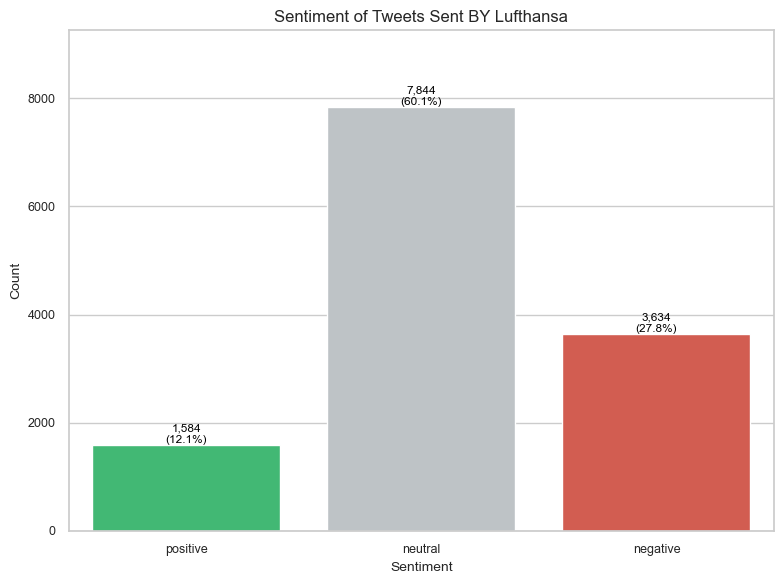


Lufthansa Sent Tweets - Sentiment Counts and Percentages:
sentiment_label
positive    1584
neutral     7844
negative    3634
Name: count, dtype: int64

Percentages:
sentiment_label
positive    12.1%
neutral     60.1%
negative    27.8%
Name: count, dtype: object

--- Lufthansa Sentiment Plotting Complete ---


In [12]:
# 2 Code to Generate "Sentiment of Tweets Sent BY Lufthansa" Graph 
if 'df3' in locals() and not df3.empty and 'airline_name' in df3.columns and 'sentiment_label' in df3.columns:
    print("\n--- Plotting Sentiment of Tweets Sent BY Lufthansa ---")

    df_lufthansa_sent_tweets = df3[df3['airline_name'] == 'Lufthansa'].copy() 

    if not df_lufthansa_sent_tweets.empty:
        print(f"Found {len(df_lufthansa_sent_tweets)} tweets sent by Lufthansa.")
        plt.figure(figsize=(8, 6)) 

        sentiment_order = ['positive', 'neutral', 'negative']
     
        plot_df_counts_lh = df_lufthansa_sent_tweets['sentiment_label'].value_counts().reindex(sentiment_order, fill_value=0)

        palette_colors = {
            'positive': '#2ECC71', 
            'neutral':  '#BDC3C7', 
            'negative': '#E74C3C'  
        }

        current_palette_lh = [palette_colors.get(label, "#CCCCCC") for label in plot_df_counts_lh.index]

        ax_lh = sns.barplot(x=plot_df_counts_lh.index, y=plot_df_counts_lh.values, palette=current_palette_lh)
        plt.title('Sentiment of Tweets Sent BY Lufthansa', fontsize=12)
        plt.xlabel('Sentiment', fontsize=10)
        plt.ylabel('Count', fontsize=10)
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)

        
        total_lufthansa_tweets = plot_df_counts_lh.sum() 
        if total_lufthansa_tweets > 0:
            for i, bar in enumerate(ax_lh.patches):
                height = bar.get_height()
                if height >= 0: 
                    percentage = (height / total_lufthansa_tweets) * 100
                    ax_lh.text(bar.get_x() + bar.get_width() / 2., height,
                            f'{int(height):,}\n({percentage:.1f}%)',
                            ha='center', va='bottom', fontsize=8.5, color='black')


        ax_lh.set_ylim(0, plot_df_counts_lh.max() * 1.18 if plot_df_counts_lh.max() > 0 else 10) 

        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_OUTPUT_DIR, 'lufthansa_sent_tweets_sentiment_exact.png'))
        plt.show()

        print("\nLufthansa Sent Tweets - Sentiment Counts and Percentages:")
        print(plot_df_counts_lh)
        if total_lufthansa_tweets > 0:
            print("\nPercentages:")
            print((plot_df_counts_lh / total_lufthansa_tweets * 100).round(1).astype(str) + '%')
    else:
        print("No tweets found sent by Lufthansa to plot sentiment distribution.")
else:
    if 'df3' not in locals() or df3.empty:
        print("DataFrame 'df3' is not loaded or is empty.")
    else:
        print("Required columns ('airline_name', 'sentiment_label') not found. Cannot plot Lufthansa sentiment.")

print("\n--- Lufthansa Sentiment Plotting Complete ---")

## Presentation 2 - Sentiment Analysis Evoluation After Airline Interaction/After Lufthansa Interaction

### DATA LOAD

#### Data DF4

In [14]:
DATA_DIR_PATH = r"C:\Users\20243898\Downloads\cleaned_sent_2_with_conversations\cleaned_sent_2_with_conversation\cleaned_sent_2_with_conversation"
PLOTS_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), 'Downloads', 'airline_sentiment_evolution_labels_plots_concise')
os.makedirs(PLOTS_OUTPUT_DIR, exist_ok=True)
print(f"Input JSONs from: {DATA_DIR_PATH}\nOutput plots to: {PLOTS_OUTPUT_DIR}")
AIRLINE_HANDLES = {'KLM':56377143,'AirFrance':106062176,'British_Airways':18332190,'AmericanAir':22536055,'Lufthansa':124476322,'AirBerlin':26223583,'easyJet':38676903,'RyanAir':1542862735,'SingaporeAir':253340062,'Qantas':218730857,'EtihadAirways':45621423,'VirginAtlantic':20626359}
AIRLINE_IDS_STR = {str(v):k for k,v in AIRLINE_HANDLES.items()}
sns.set(style="whitegrid"); pd.options.display.max_columns=60; pd.options.display.float_format='{:.3f}'.format

# 1 Data Loading & Preparation 
all_files = glob.glob(os.path.join(DATA_DIR_PATH, '*_cleaned.json'))
if not all_files: print(f"ERROR: No files in {DATA_DIR_PATH}."); df4=pd.DataFrame()
else:
    li = [pd.DataFrame.from_records([json.loads(line) for line in f if line.strip()])
          for filename in all_files
          for f in [open(filename, 'r', encoding='utf-8')] if os.path.exists(filename)]
    df4 = pd.concat(li, axis=0, ignore_index=True) if li else pd.DataFrame()
    print(f"Loaded {len(df4):,} rows from {len(li)} files.")

if not df4.empty:
    if 'user' in df4.columns:
        user_df4=pd.json_normalize(df4['user'].fillna({})).add_prefix('user_')
        df4=pd.concat([df.drop('user',axis=1,errors='ignore'),user_df4[[c for c in ['user_id_str'] if c in user_df4.columns]]],axis=1)
    if 'entities' in df4.columns:
        df4['hashtags_list']=df4['entities'].apply(lambda x:[ht.get('text','').lower() for ht in x.get('hashtags',[]) if isinstance(ht,dict) and ht.get('text')] if isinstance(x,dict) else [])
        df4.drop('entities',axis=1,errors='ignore',inplace=True)
    else: df4['hashtags_list']=[[] for _ in range(len(df4))]
    if 'sentiment_max' in df4.columns: df4['sentiment_label']=df4['sentiment_max'].map({'neg':'negative','neu':'neutral','pos':'positive'}).astype('category')
    elif 'sentiment_label' not in df4.columns: df4['sentiment_label']=pd.Series(dtype='category')
    if 'created_at' in df4.columns: df4['created_at']=pd.to_datetime(df4['created_at'],errors='coerce')
    if 'user_id_str' in df4.columns:
        df4['user_id_str']=df4['user_id_str'].astype('string'); df4['airline_name']=df4['user_id_str'].map(AIRLINE_IDS_STR).astype('category'); df4['is_airline_tweet']=df4['airline_name'].notna()
    else: df4['airline_name']=pd.Series(dtype='category'); df4['is_airline_tweet']=pd.Series(dtype='boolean')
    for col in ['conversation_index']:
        if col in df4.columns: df4[col]=pd.to_numeric(df4[col],errors='coerce').astype('Int64')
        else: df4[col]=pd.Series(dtype='Int64')
    for col in ['id_str','in_reply_to_status_id_str','in_reply_to_user_id_str','conversation_root']:
        if col in df4.columns: df4[col]=df4[col].astype('string')
    print("Prep complete.")

Input JSONs from: C:\Users\20243898\Downloads\cleaned_sent_2_with_conversations\cleaned_sent_2_with_conversation\cleaned_sent_2_with_conversation
Output plots to: C:\Users\20243898\Downloads\airline_sentiment_evolution_labels_plots_concise


MemoryError: Unable to allocate 1.97 MiB for an array with shape (13585, 19) and data type object

## Visualization Code

### Visualization 4 & 5

In [ ]:
# 2 Sentiment Evolution Analysis
if not df4.empty and all(c in df4.columns for c in ['conversation_root','conversation_index','sentiment_label','is_airline_tweet']):
    print("\n--- Analyzing Sentiment Evolution (Label Transitions) ---")
    df4_convos=df4.sort_values(['conversation_root','conversation_index'])
    for col, shift_col in {'sentiment_label':'prev_sentiment_label', 'is_airline_tweet':'prev_is_airline', 'airline_name':'prev_airline_name'}.items():
        df4_convos[shift_col] = df4_convos.groupby('conversation_root')[col].shift(1)

    df4_cust_after_airline=df4_convos[(df4_convos['conversation_index']>0)&(df4_convos['prev_is_airline']==True)&(df4_convos['is_airline_tweet']==False)&(df4_convos['prev_sentiment_label'].notna())&(df4_convos['sentiment_label'].notna())].copy()
    print(f"Found {len(df4_cust_after_airline)} customer tweets after airline tweet.")

    def categorize_evolution(prev,curr):
        if pd.isna(prev) or pd.isna(curr): return 'Unknown/NA'
        if curr=='negative' and prev in ['neutral','positive']: return 'Worsened'
        if curr=='positive' and prev in ['negative','neutral']: return 'Improved'
        if curr=='neutral' and prev=='negative': return 'Improved (To Neutral)'
        if curr==prev: return f'Stayed {curr.capitalize()}'
        if curr=='neutral' and prev=='positive': return 'Became Neutral (from Pos)'
        return 'Other Transition'

    if not df4_cust_after_airline.empty:
        df4_cust_after_airline['evolution_strict']=df4_cust_after_airline.apply(lambda r:categorize_evolution(r['prev_sentiment_label'],r['sentiment_label']),axis=1)
        evo_s_counts=df4_cust_after_airline['evolution_strict'].value_counts(normalize=True).mul(100)
        print("\nSentiment Evolution (Strict Categories, %):\n", evo_s_counts.to_frame())

        plot_cats={'Worsened':['Worsened'],'Improved':['Improved','Improved (To Neutral)'],'Same/Neutral':['Stayed Negative','Stayed Neutral','Stayed Positive','Became Neutral (from Pos)','Other Transition','Unknown/NA']}
        df4_cust_after_airline['evo_plot_cat']='Other'
        for main_c,sub_cs in plot_cats.items(): df4_cust_after_airline.loc[df4_cust_after_airline['evolution_strict'].isin(sub_cs),'evo_plot_cat']=main_c
        
        plot_cts=df4_cust_after_airline['evo_plot_cat'].value_counts(normalize=True).mul(100)
        p_order=['Improved','Same/Neutral','Worsened']; p_order_pres=[c for c in p_order if c in plot_cts.index]
        
        if not plot_cts.empty:
            plt.figure(figsize=(8,6)); ax=sns.barplot(x=plot_cts.index,y=plot_cts.values,order=p_order_pres,palette={'Improved':'darkgreen','Same/Neutral':'lightgrey','Worsened':'red'})
            plt.title('Sentiment Evolution After Airline Interaction'); plt.ylabel('% Instances'); plt.xlabel('Evolution Category'); plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
            for p in ax.patches: ax.annotate(f'{p.get_height():.1f}%',(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='center',xytext=(0,5),textcoords='offset points',fontsize=10)
            ax.set_ylim(top=ax.get_ylim()[1]*1.1); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_OUTPUT_DIR,'sentiment_evolution_strict_cats.png')); plt.show()

        df4_cust_after_lh=df4_cust_after_airline[df4_cust_after_airline['prev_airline_name']=='Lufthansa']
        if not df4_cust_after_lh.empty:
            print(f"\nFound {len(df4_cust_after_lh)} customer replies after Lufthansa tweet.")
            lh_evo_plot_cts=df4_cust_after_lh['evo_plot_cat'].value_counts(normalize=True).mul(100)
            if not lh_evo_plot_cts.empty:
                plt.figure(figsize=(8,6)); ax_lh=sns.barplot(x=lh_evo_plot_cts.index,y=lh_evo_plot_cts.values,order=p_order_pres,palette={'Improved':'darkgreen','Same/Neutral':'lightgrey','Worsened':'red'})
                plt.title('Sentiment Evolution After Lufthansa Interaction'); plt.ylabel('% Instances'); plt.xlabel('Evolution Category'); plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
                for p in ax_lh.patches: ax_lh.annotate(f'{p.get_height():.1f}%',(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='center',xytext=(0,5),textcoords='offset points',fontsize=10)
                ax_lh.set_ylim(top=ax_lh.get_ylim()[1]*1.1); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_OUTPUT_DIR,'lufthansa_sentiment_evolution_strict.png')); plt.show()
else: print("DataFrame empty or key columns missing. Skipping Sentiment Evolution.")
print("\n--- Sentiment Evolution (Label-Based) Exploration Complete ---")
